In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 2000

feature_dims = ["Color", "Shape", "Pattern"]

### Get Firing Rates, Beh data

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [4]:
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_100_bins.pickle"))
firing_rates = firing_rates[firing_rates.TrialNumber >= 57]

In [12]:
print(f"Correct trials: {len(valid_beh[valid_beh.Response == 'Correct'])}")
print(f"Incorrect trials: {len(valid_beh[valid_beh.Response == 'Incorrect'])}")

Correct trials: 946
Incorrect trials: 746


### Train/Test FB Decoder

In [20]:
num_neurons = len(firing_rates.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/fb_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/fb_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


### Replot decoder accuracy

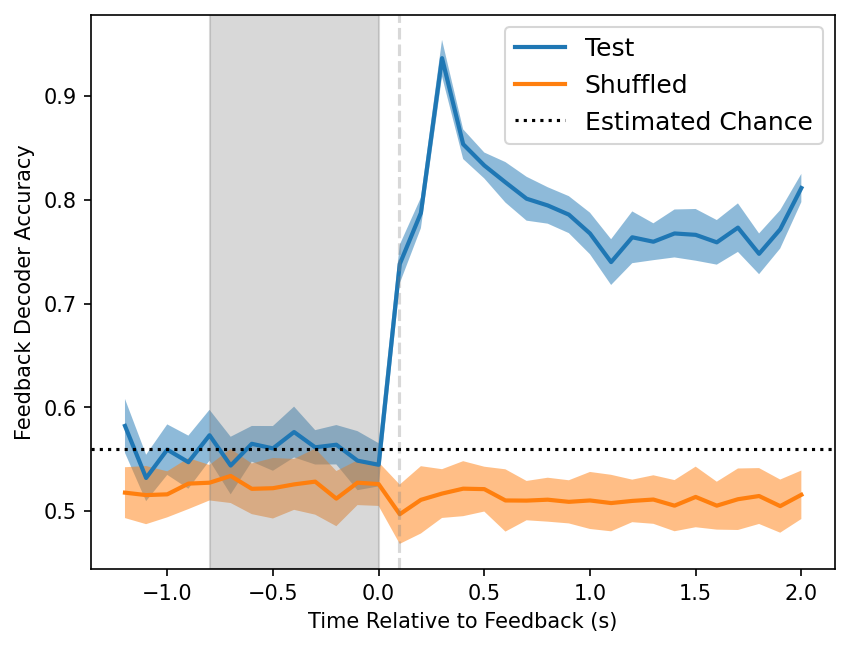

In [21]:
test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))
shuffled_accs = np.load(fs.open(f"l2l.pqz317.scratch/fb_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Test",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    1.3, 2, .1,    
    ax,
    label="Shuffled",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.56, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


### Split by Ant/Tmp

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evalua

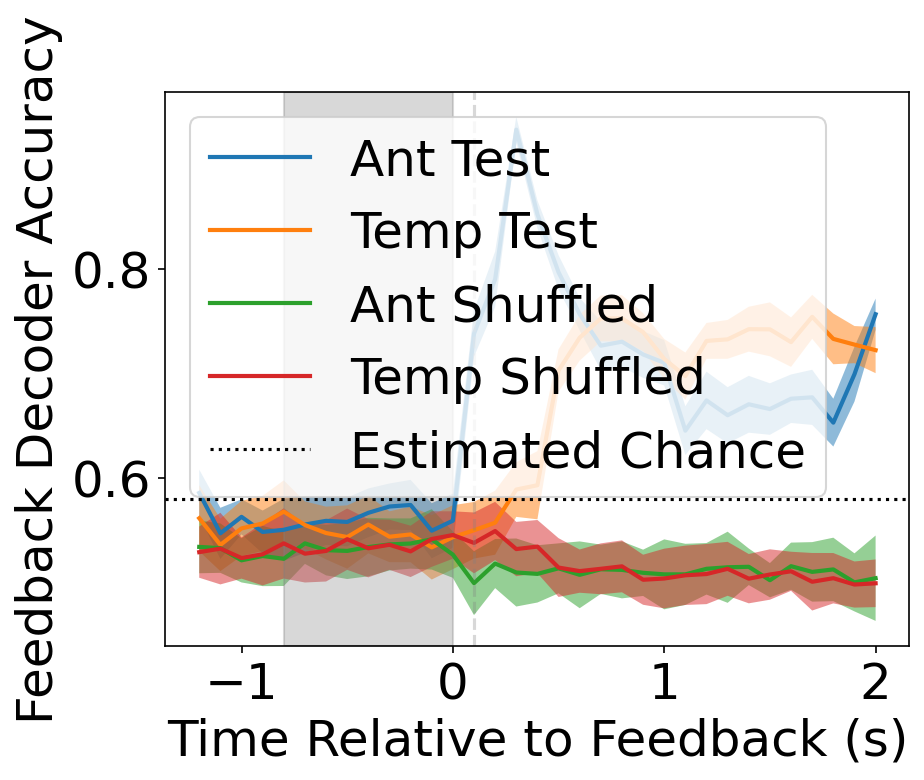

In [29]:
temp_units = spike_utils.get_temporal_drive_unit_ids(fs, subject, session)
ant_units = spike_utils.get_anterior_drive_unit_ids(fs, subject, session)

temp_firing_rates = firing_rates[firing_rates.UnitID.isin(temp_units)]
ant_firing_rates = firing_rates[firing_rates.UnitID.isin(ant_units)]

num_neurons = len(temp_firing_rates.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = temp_firing_rates.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

temp_train_accs_by_bin, temp_test_accs_by_bin, temp_shuffled_accs, temp_models, temp_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

num_neurons = len(ant_firing_rates.UnitID.unique())
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

ant_inputs = ant_firing_rates.rename(columns={mode: "Value"})
ant_train_accs_by_bin, ant_test_accs_by_bin, ant_shuffled_accs, ant_models, ant_splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, ant_inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    ant_test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Ant Test",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    temp_test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Temp Test",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    ant_shuffled_accs,
    1.3, 2, .1,
    ax,
    label="Ant Shuffled",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    temp_shuffled_accs,
    1.3, 2, .1,
    ax,
    label="Temp Shuffled",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.58, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
ax.legend()
fig.show()

### Cross Decodability Plots

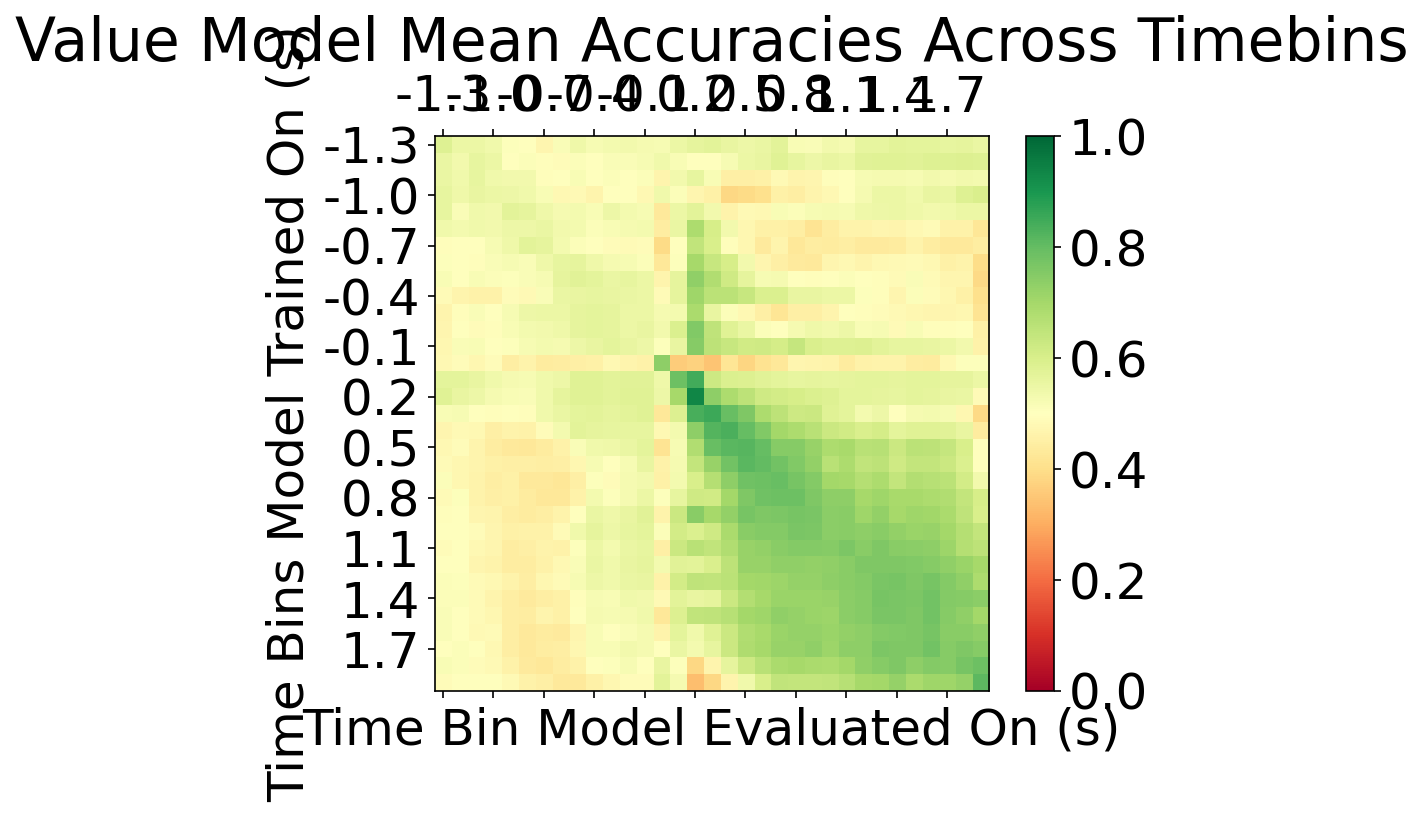

In [30]:
models = np.load(fs.open(f"l2l.pqz317.scratch/fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
splits = pickle.load(fs.open(f"l2l.pqz317.scratch/fb_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))


mode = "SpikeCounts"

inputs = firing_rates.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

bins = np.arange(0, 3.3, 0.1)

cross_accs = classifier_utils.cross_evaluate_by_time_bins(models, inputs, labels, splits, bins)

np.save(fs.open(f"l2l.pqz317.scratch/feedback_cross_decodability.npy", "wb"), cross_accs)

fig, ax = plt.subplots()
colors = ax.matshow(cross_accs, cmap="RdYlGn", vmin=0, vmax=1)
fig.colorbar(colors)
axis = np.arange(0, 33, 3)
labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(axis)
ax.set_yticks(axis)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Time Bin Model Evaluated On (s)")
ax.set_ylabel("Time Bins Model Trained On (s)")
ax.set_title(f"Value Model Mean Accuracies Across Timebins")
fig.savefig("../data/feedback_cross_decodability.pdf")
fig.show()

### Look at Weights

In [6]:
electrode_pos = lfp_development.get_electrode_xyz(fs, "nhp", subject, "WCST", str(session), chans_spc="all")

np_pos = electrode_pos[['x', 'y', 'z']].to_numpy()
spatial_clusters = KMeans(n_clusters=5, random_state=0).fit_predict(np_pos)
electrode_pos["spatial_cluster"] = spatial_clusters 

In [7]:
name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}

spatial_cluster_mapping = np.array(["anterior hippocampus", "mpfc", "parietal", "posterior hippocampus", "lpfc/fef"])
electrode_pos["SpatialClusterName"] = spatial_cluster_mapping[electrode_pos["spatial_cluster"]]

In [8]:
np.unique(spatial_clusters, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([61, 58, 26, 38, 37]))

In [9]:
units = spike_general.list_session_units(fs, subject, session)

unit_pos = pd.merge(units, electrode_pos, left_on="Channel", right_on="ch", how="left")
unit_pos = unit_pos.astype({"UnitID": int})

In [26]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="SpatialClusterName", 
    labels={"SpatialClusterName": "Unit Location"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.55,
        xanchor="left",
        x=1,
        font=dict(
            size = 20
        )
    ),
    legend_title = dict(
        font = dict(size = 20))
)
fig.write_html("../data/fb_spike_spatial_clusters.html")

In [10]:
unit_spatial_cluster = unit_pos.spatial_cluster.values

mpfc = np.argwhere(unit_spatial_cluster == 1)
lpfc = np.argwhere(unit_spatial_cluster == 4)
ant_hipp = np.argwhere(unit_spatial_cluster == 0)
post_hipp = np.argwhere(unit_spatial_cluster == 3)
parietal = np.argwhere(unit_spatial_cluster == 2)

reordered_units = np.squeeze(np.concatenate((mpfc, lpfc, parietal, post_hipp, ant_hipp)))

regs = [mpfc, lpfc, parietal, post_hipp, ant_hipp]
lens = [len(reg) for reg in regs]
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

[15.5 29.5 35.5 36.5]
6


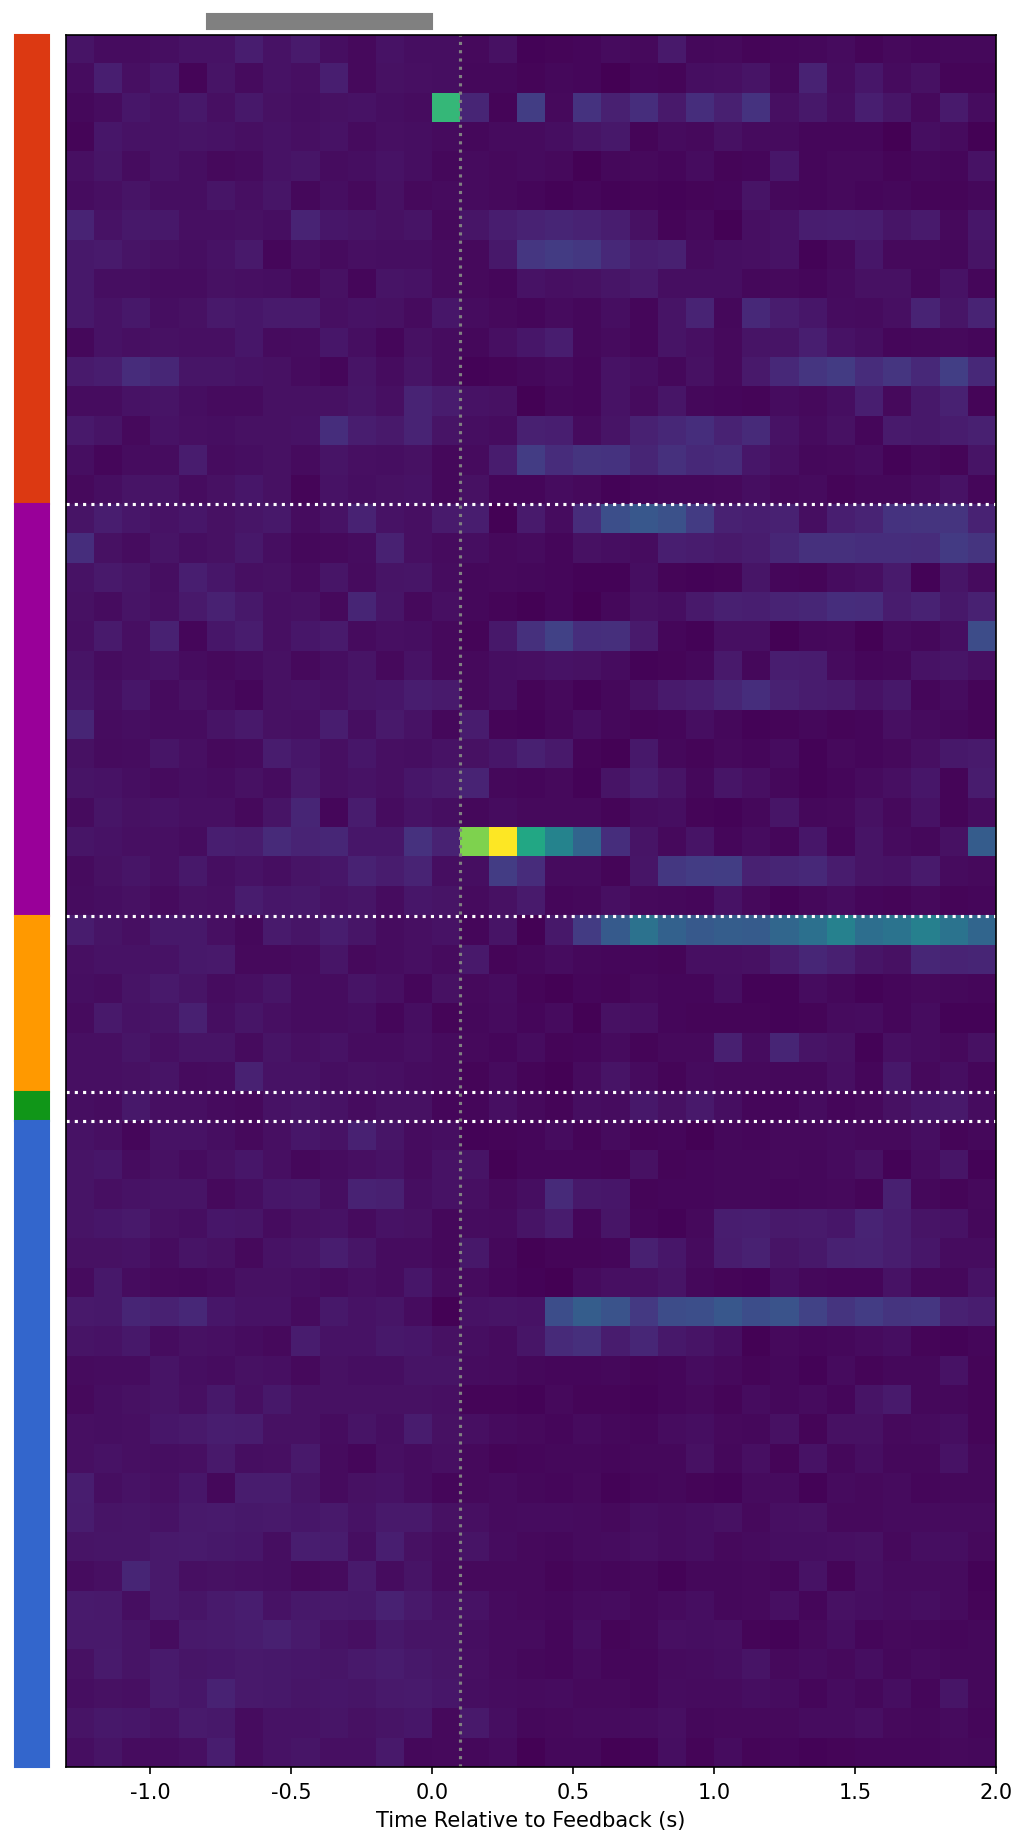

In [98]:
name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}
colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]

# models are num_time_points x num_models
pre_interval = 1300
post_interval = 2000
models = np.load(fs.open(f"l2l.pqz317.scratch/fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 2)

sums = np.sum(weights, axis=0)

normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5, 2.0])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")

for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")


### DV Stuff

In [5]:
pre_interval = 1300
post_interval = 2000

models = np.load(fs.open(f"l2l.pqz317.scratch/fb_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)


In [7]:
# Look at just time at 0.2s after FB onset, 
model = models[15, 0]
time_bin = 1.5

mode = "SpikeCounts"
inputs = firing_rates.rename(columns={mode: "Value"})
inputs = inputs[np.isclose(inputs["TimeBins"], time_bin)]

In [8]:
model.labels_to_idx

{'Incorrect': 0, 'Correct': 1}

In [9]:
x_test = classifier_utils.transform_to_input_data(inputs)
device = "cuda" if torch.cuda.is_available() else "cpu"
x_test = torch.Tensor(x_test).to(device)
y_test = model.model(x_test)

In [10]:
probs = y_test.softmax(dim=1)

In [11]:
dv = torch.log(probs[:, 0] / probs[:, 1])

In [12]:
np_dv = dv.detach().cpu().numpy()

In [94]:
cor_inc = valid_beh[valid_beh.BlockNumber <= 6].Response

In [96]:
cor_idxs = np.argwhere(cor_inc.to_numpy() == "Correct").squeeze()
inc_idxs = np.argwhere(cor_inc.to_numpy() == "Incorrect").squeeze()

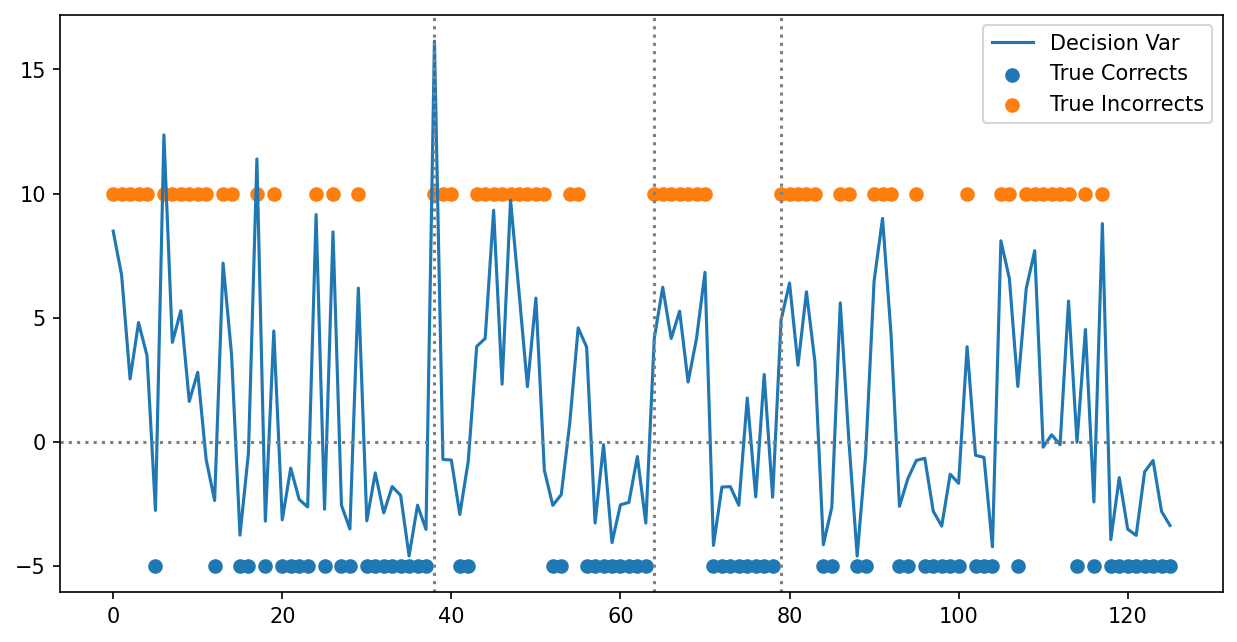

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np_dv[:(183 - 57)], label="Decision Var")
ax.scatter(cor_idxs, np.ones(len(cor_idxs)) * -5, label="True Corrects")
ax.scatter(inc_idxs, np.ones(len(inc_idxs)) * 10, label="True Incorrects")
ax.axvline(95 - 57, color="gray", linestyle="dotted")
ax.axvline(121 - 57, color="gray", linestyle="dotted")
ax.axvline(136 - 57, color="gray", linestyle="dotted")
ax.axhline(0, color="gray", linestyle="dotted")
ax.legend()

### Create DV data for all models, all time points

In [18]:
dvs = np.empty((models.shape[0], models.shape[1], len(valid_beh)))
for time_idx in range(models.shape[0]):
    for model_idx in range(models.shape[1]):
        model = models[time_idx, model_idx]
        time_bin = time_idx / 10
        mode = "SpikeCounts"
        inputs = firing_rates.rename(columns={mode: "Value"})
        inputs = inputs[np.isclose(inputs["TimeBins"], time_bin)]

        x_test = classifier_utils.transform_to_input_data(inputs)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        x_test = torch.Tensor(x_test).to(device)
        y_test = model.model(x_test)
        probs = y_test.softmax(dim=1)
        dv = torch.log(probs[:, 0] / probs[:, 1])
        np_dv = dv.detach().cpu().numpy()
        dvs[time_idx, model_idx, :] = np_dv

In [20]:
np.save(fs.open(f"l2l.pqz317.scratch/fb_decision_vars.npy", "wb"), dvs)

In [ ]:
valid_beh.to_csv(fs.open("l2l.pqz317.scratch/fb_decoder_trials.npy", "wb"))

### Look at LFP data

In [12]:
lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))

/tmp/ipykernel_1187002/4004171884.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))


In [13]:
valid_lfp = lfp[lfp.TrialNumber.isin(valid_beh.TrialNumber.unique())]

In [15]:
valid_lfp.TimeBins.unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7])

In [25]:
freqs = ["bp_4-5", "bp_10-13", "bp_20-24", "bp_27-37", "bp_65-87", "bp_120-148"]
for freq in freqs:
    pre_interval = 1300
    post_interval = 1500
    num_channels = len(valid_lfp.ChanNum.unique())

    classes = valid_beh.Response.unique()
    init_params = {"n_inputs": num_channels, "n_classes": len(classes)}
    trainer = Trainer(learning_rate=0.05, max_iter=1000)
    wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

    inputs = valid_lfp.rename(columns={freq: "Value", "ChanNum": "UnitID"})
    labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
    train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )
    np.save(fs.open(f"l2l.pqz317.scratch/fb_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/fb_lfp_{freq}shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
    np.save(fs.open(f"l2l.pqz317.scratch/fb_lfp_{freq}_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
    pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/fb_lfp_{freq}_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))      

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

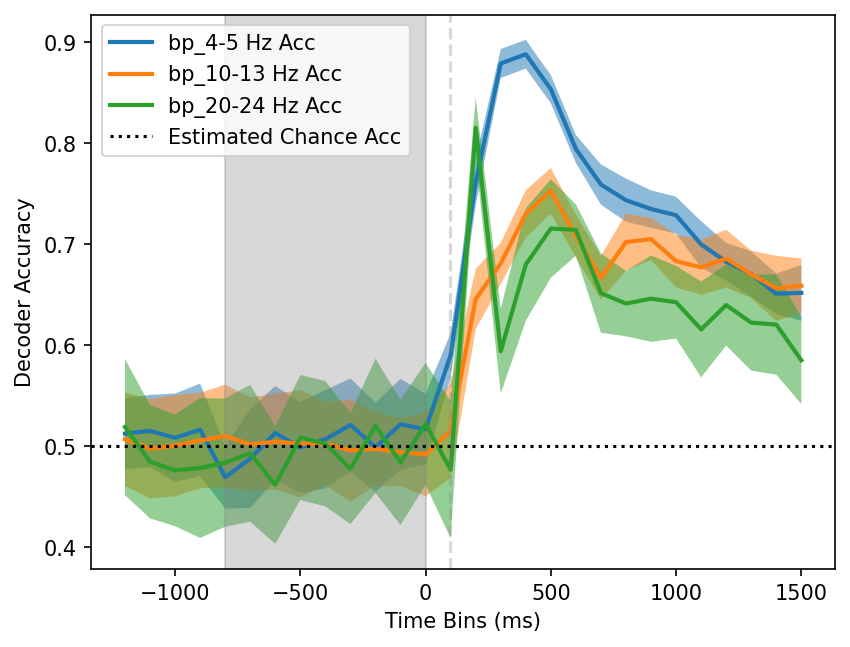

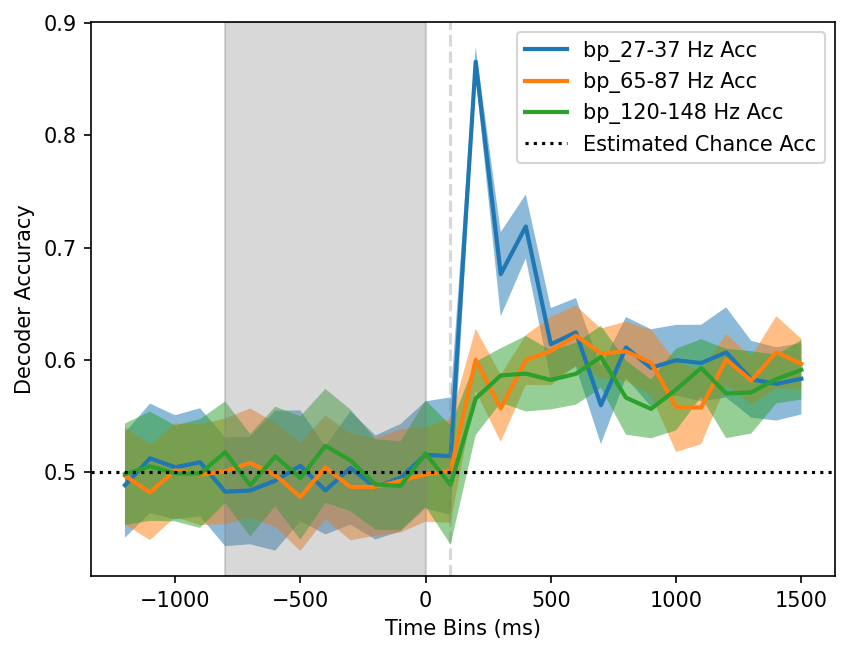

In [4]:
pre_interval = 1300
post_interval = 1500

def viz_for_bands(freqs, pre_interval, post_interval, level):
    fig, ax = plt.subplots()
    for freq in freqs:
        acc = np.load(fs.open(f"l2l.pqz317.scratch/fb_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            pre_interval, post_interval, 100,
            ax,
            label=f"{freq} Hz Acc",
            right_align=True,
        )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance Acc")
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend()
    fig.savefig(f"../data/lfp_fb_{level}_bands.pdf")

lower_freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
viz_for_bands(lower_freqs, pre_interval, post_interval, "lower")
higher_freqs = ["bp_27-37", "bp_65-87", "bp_120-148"]
viz_for_bands(higher_freqs, pre_interval, post_interval, "higher")




In [4]:
valid_beh.BlockNumber.unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55])

### Drop Unit 52

In [120]:
firing_rates_dropped = firing_rates[~(firing_rates.UnitID == 52)]

In [121]:
num_neurons = len(firing_rates_dropped.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01, max_iter=1000)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates_dropped.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_one_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_one_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_one_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/fb_drop_one_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


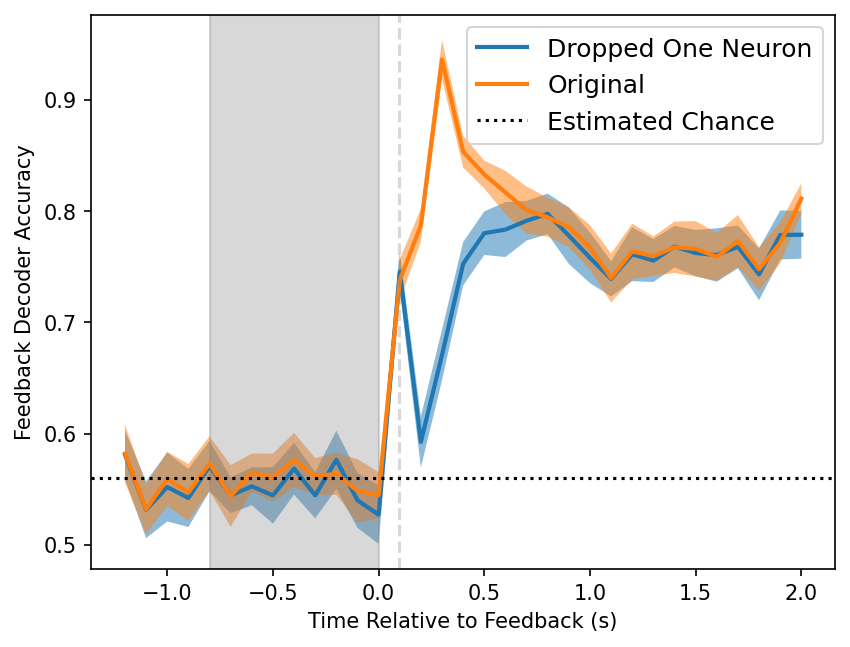

In [122]:
test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_drop_one_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

no_drop_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Dropped One Neuron",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    no_drop_accs_by_bin,
    1.3, 2, .1,    
    ax,
    label="Original",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.56, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


### Look at Firing Rates for Unit 52

In [39]:
firing_rates_50 = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_50_bins.pickle"))


In [43]:
unit_fr = firing_rates_50[firing_rates_50.UnitID == 52]
cor_trials = valid_beh[valid_beh.Response == 'Correct'].TrialNumber
inc_trials = valid_beh[valid_beh.Response == 'Incorrect'].TrialNumber

cor_fr = unit_fr[unit_fr.TrialNumber.isin(cor_trials)]
inc_fr = unit_fr[unit_fr.TrialNumber.isin(inc_trials)]

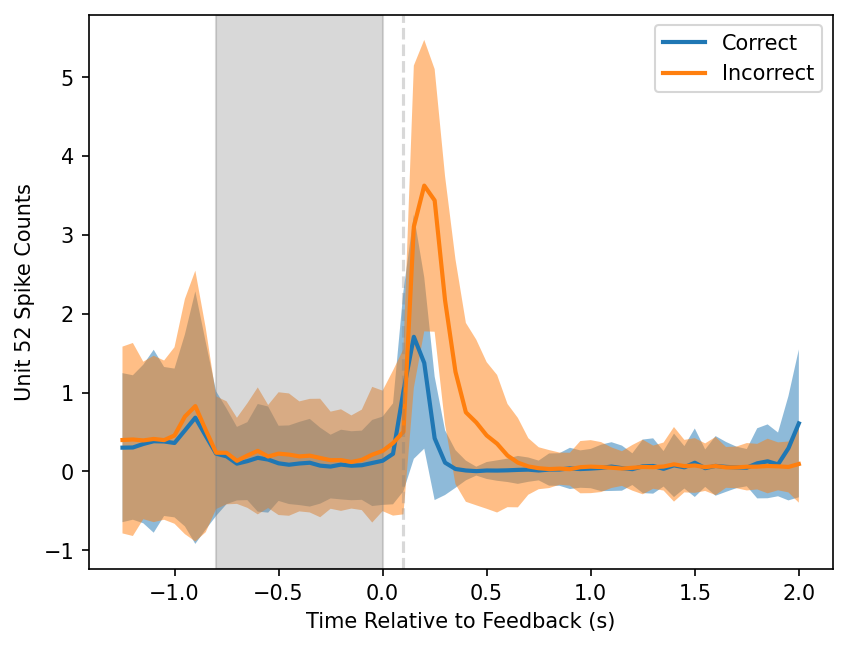

In [60]:
trans_cor = np.stack(cor_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())
trans_inc = np.stack(inc_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    trans_cor,
    1.3, 2, .05,
    ax,
    label="Correct",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    trans_inc,
    1.3, 2, .05,
    ax,
    label="Incorrect",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Unit 52 Spike Counts")
ax.legend()
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")


In [78]:
# look at incorrect peak
# index 29 -> TimeBins 29 * 0.05
max_time_bin = 1.45
max_unit_fr = unit_fr[np.isclose(unit_fr.TimeBins, 1.45)]
max_unit_fr_inc = max_unit_fr[max_unit_fr.TrialNumber.isin(inc_trials)]
trials_since = valid_beh[["TrialNumber", "TrialAfterRuleChange"]]

In [97]:
merged = pd.merge(max_unit_fr_inc, trials_since, on="TrialNumber", how="inner")
grouped = merged.groupby(["TrialAfterRuleChange"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy())

ValueError: all input arrays must have the same shape

In [133]:
fig1 = px.scatter_3d(
    unit_pos[unit_pos.UnitID == 9], x="x", y="y", z="z", 
    color="SpatialClusterName", 
    labels={"SpatialClusterName": "Unit Location"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.55,
        xanchor="left",
        x=1,
        font=dict(
            size = 20
        )
    ),
    legend_title = dict(
        font = dict(size = 20))
)
fig.write_html("../data/fb_dropout_9.html")

### Drop Unit 0, 9

In [102]:
reordered[:, 23]

array([0.01133618, 0.01463123, 0.02551821, 0.01576152, 0.00906659,
       0.00947103, 0.00717635, 0.01451754, 0.01397916, 0.01055244,
       0.01163001, 0.01162045, 0.00964996, 0.02729721, 0.0332532 ,
       0.01132943, 0.02590149, 0.02148564, 0.00870985, 0.02551761,
       0.014626  , 0.02142664, 0.02910265, 0.01080781, 0.01147447,
       0.01818497, 0.00838918, 0.00986112, 0.0462056 , 0.01711345,
       0.0711895 , 0.01469006, 0.01416762, 0.00905407, 0.02552466,
       0.01163135, 0.01412763, 0.01105213, 0.01074727, 0.01070445,
       0.02357993, 0.02251129, 0.00862931, 0.06621026, 0.01447897,
       0.0119017 , 0.00914118, 0.01124015, 0.01072172, 0.00828975,
       0.01553774, 0.01183726, 0.01100212, 0.0104312 , 0.01475443,
       0.01398955, 0.01208284, 0.01188493, 0.01328994])

In [107]:
np.argwhere(reordered[:, 23] > 0.05)

array([[30],
       [43]])

In [113]:
reordered_units[43]

9

In [114]:
firing_rates_dropped = firing_rates[~(firing_rates.UnitID == 0)]
num_neurons = len(firing_rates_dropped.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01, max_iter=1000)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates_dropped.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/fb_drop_0_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


In [130]:
firing_rates_dropped = firing_rates[~((firing_rates.UnitID == 9) | (firing_rates.UnitID == 0))]
num_neurons = len(firing_rates_dropped.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01, max_iter=1000)
wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates_dropped.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 3.3, 0.1), random_splitter
)

np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_9_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_9_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
np.save(fs.open(f"l2l.pqz317.scratch/fb_drop_0_9_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/fb_drop_0_9_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 2.8000000000000003
Evaluating for bin 2.9000000000000004
Evaluating for bin 3.0
Evaluating for bin 3.1
Evaluating for bin 3.2


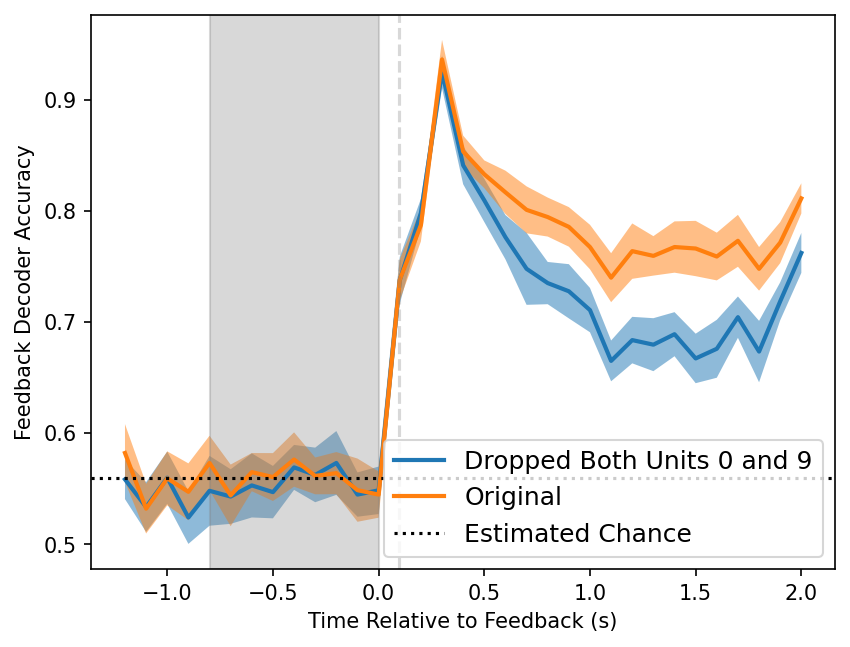

In [131]:
test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_drop_0_9_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

no_drop_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Dropped Both Units 0 and 9",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    no_drop_accs_by_bin,
    1.3, 2, .1,    
    ax,
    label="Original",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.56, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


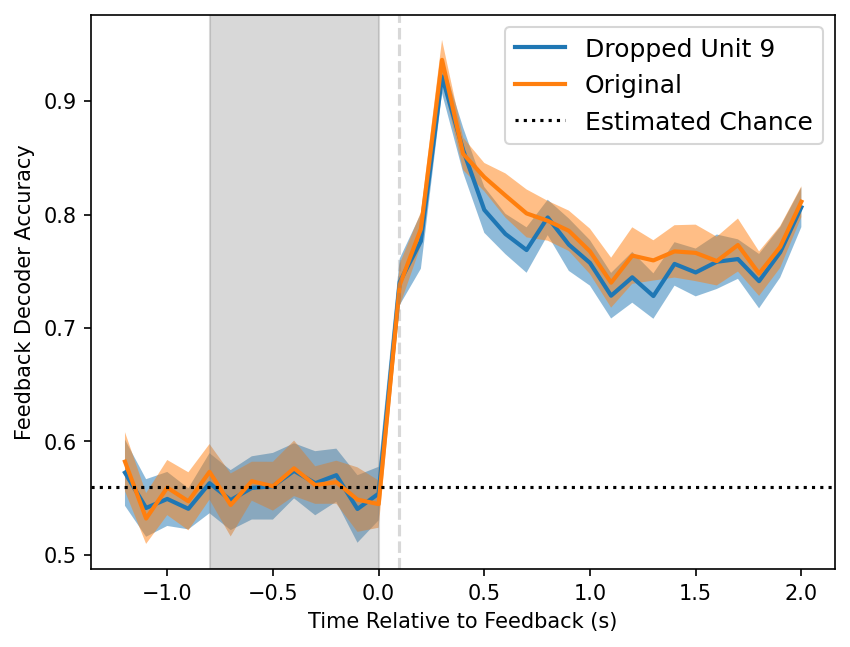

In [118]:
test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_drop_9_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

no_drop_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/fb_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 2, .1,
    ax,
    label="Dropped Unit 9",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    no_drop_accs_by_bin,
    1.3, 2, .1,    
    ax,
    label="Original",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.56, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Feedback Decoder Accuracy")
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")
ax.legend(prop={'size': 12})
# fig.savefig(fs.open("l2l.pqz317.scratch/figs/value_normed_model.pdf", "wb"))
# fig.savefig("../data/value_normed_model.pdf")
# fig.show()


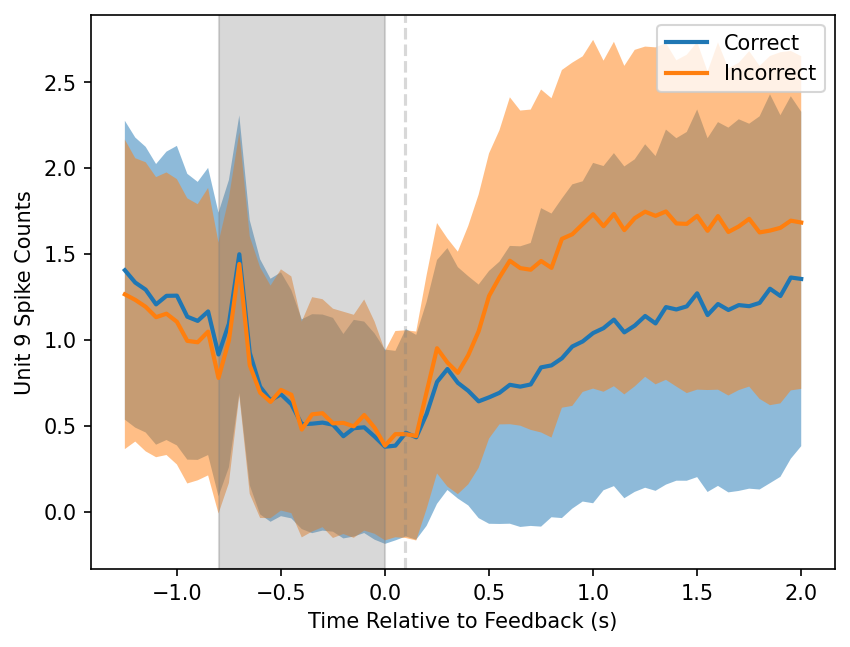

In [126]:
unit_fr = firing_rates_50[firing_rates_50.UnitID == 9]
cor_trials = valid_beh[valid_beh.Response == 'Correct'].TrialNumber
inc_trials = valid_beh[valid_beh.Response == 'Incorrect'].TrialNumber

cor_fr = unit_fr[unit_fr.TrialNumber.isin(cor_trials)]
inc_fr = unit_fr[unit_fr.TrialNumber.isin(inc_trials)]

trans_cor = np.stack(cor_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())
trans_inc = np.stack(inc_fr.groupby(["TimeBins"], as_index=False).apply(lambda x: x["SpikeCounts"].to_numpy()).to_numpy())

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    trans_cor,
    1.3, 2, .05,
    ax,
    label="Correct",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    trans_inc,
    1.3, 2, .05,
    ax,
    label="Incorrect",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Unit 9 Spike Counts")
ax.legend()
# ax.set_title(f"Decoding Choice with 100ms Bins of Spiking")


In [145]:
cor_trials = valid_beh[valid_beh.Response == 'Correct'].TrialNumber
inc_trials = valid_beh[valid_beh.Response == 'Incorrect'].TrialNumber

unit_0_fr = firing_rates_50[(firing_rates_50.UnitID == 0) & np.isclose(firing_rates_50.TimeBins, 2.3)]
unit_9_fr = firing_rates_50[(firing_rates_50.UnitID == 9) & np.isclose(firing_rates_50.TimeBins, 2.3)]

cor_0_fr = unit_0_fr[unit_0_fr.TrialNumber.isin(cor_trials)]
inc_0_fr = unit_0_fr[unit_0_fr.TrialNumber.isin(inc_trials)]

cor_9_fr = unit_9_fr[unit_9_fr.TrialNumber.isin(cor_trials)]
inc_9_fr = unit_9_fr[unit_9_fr.TrialNumber.isin(inc_trials)]

Text(0, 0.5, 'Firing Rate 1s after Feedback')

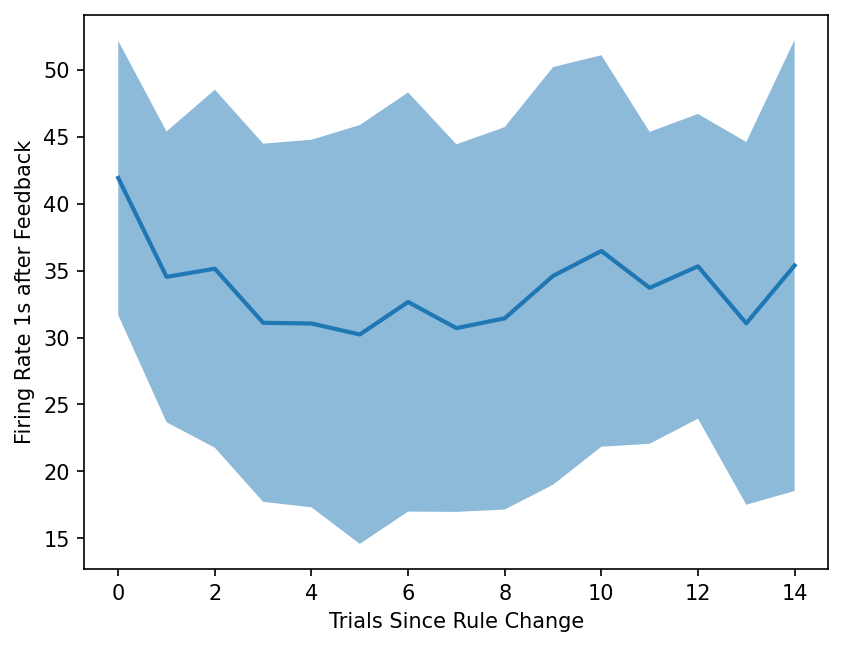

In [177]:
merged = pd.merge(inc_9_fr, trials_since, on="TrialNumber", how="inner")
grouped = merged.groupby(["TrialAfterRuleChange"], as_index=False).apply(lambda x: x["FiringRate"].to_numpy())

fig, ax = plt.subplots()
sub_groups  = grouped[:15]
means = np.empty(len(sub_groups))
stds = np.empty(len(sub_groups))
for i, group in enumerate(sub_groups):
    means[i] = np.mean(group)
    stds[i] = np.std(group)
mean_line, = ax.plot(np.arange(len(sub_groups)), means, linewidth=2)
std_line = ax.fill_between(np.arange(len(sub_groups)), means - stds, means + stds, alpha=0.5)
ax.set_xlabel("Trials Since Rule Change")
ax.set_ylabel("Firing Rate 1s after Feedback")


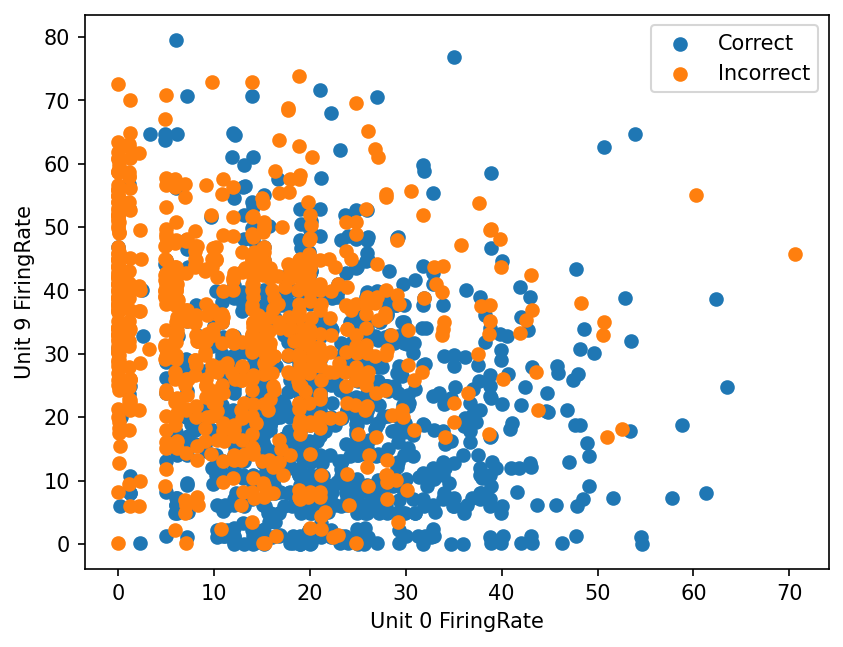

In [149]:
fig, ax = plt.subplots()
ax.scatter(cor_0_fr.FiringRate, cor_9_fr.FiringRate, label="Correct")
ax.scatter(inc_0_fr.FiringRate, inc_9_fr.FiringRate, label="Incorrect")
ax.set_xlabel("Unit 0 FiringRate")
ax.set_ylabel("Unit 9 FiringRate")
ax.legend()


### Drop Other Unit

In [180]:
reordered[:, 14]

array([0.0120236 , 0.01046521, 0.02890563, 0.01050082, 0.01268649,
       0.01228331, 0.01882641, 0.01138569, 0.01201345, 0.01336988,
       0.01106894, 0.00788652, 0.01658903, 0.01407896, 0.01277407,
       0.01604472, 0.02380546, 0.01452783, 0.01085723, 0.01065935,
       0.0090687 , 0.0120253 , 0.01156763, 0.02275491, 0.01566927,
       0.02808621, 0.01084653, 0.18437596, 0.01417502, 0.01265006,
       0.00952827, 0.02108295, 0.01123156, 0.01114133, 0.01119277,
       0.00936096, 0.00970174, 0.00806605, 0.0175288 , 0.01532814,
       0.01304138, 0.02035741, 0.01206318, 0.01718564, 0.01460447,
       0.0133896 , 0.00930998, 0.01467956, 0.01125491, 0.01166911,
       0.01537075, 0.01737946, 0.01148995, 0.01705103, 0.01407705,
       0.01525615, 0.01386561, 0.02078273, 0.01103725])